<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML321ENSkillsNetwork817-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Collaborative Filtering based Recommender System using Non-negative Matrix Factorization**


Estimated time needed: **60** minutes


In the previous lab, we have performed KNN on user-item interaction matrix to estimate the rating of unknown items based on the aggregation of the user's K nearest neighbor's ratings. Finding nearest neighbors are based on similarity measurements among users or items with big similarity matrices. 


The KNN algorithm is memory-based which means we need to keep all instances for prediction and maintain a big similarity matrix. These can be infeasible if our user/item scale is large, for example, 1 million users will require a 1 million by 1 million similarity matrix, which is very hard to load into RAM for most computation environments.


#### Non-negative matrix factorization


In the machine learning course, you have learned a dimensionality reduction algorithm called Non-negative matrix factorization (NMF), which decomposes a big sparse matrix into two smaller and dense matrices.

Non-negative matrix factorization can be one solution to big matrix issues. The main idea is to decompose the big and sparse user-interaction into two smaller dense matrices, one represents the transformed user features and another represents the transformed item features.


An example is shown below, suppose we have a user-item interaction matrix $A$ with 10000 users and 100 items (10000 x 100), and its element `(j, k)` represents the rating of item `k` from user `j`. Then we could decompose $A$ into two smaller and dense matrices $U$ (10000 x 16) and $I$ (16 x 100). for user matrix $U$, each row vector is a transformed latent feature vector of a user, and for the item matrix $I$, each column is a transformed latent feature vector of an item. 

Here the dimension 16 is a hyperparameter defines the size of the hidden user and item features, which means now the shape of transposed user feature vector and item feature vector is now 16 x 1.


The magic here is when we multiply the row `j` of $U$ and column `k` of matrix $I$, we can get an estimation to the original rating $\hat{r}_{jk}$. 

For example, if we preform the dot product user ones  row vector in $U$ and item ones  column vector in $I$, we can get the rating estimation of user one to item one, which is the element (1, 1) in the original interaction matrix $I$. 


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_4/images/nmf.png)


Note $I$ is short for Items, and it is not an identity matrix.


Then how do we figure out the values in $U$ and $I$ exactly? Like many other machine learning processes, we could start by initializing the values of $U$ and $I$, then define the following distance or cost function to be minimized:


$$\sum_{r_{jk} \in {train}} \left(r_{jk} - \hat{r}_{jk} \right)^2,$$


where $\hat{r}_{ij}$ is the dot product of $u_j^T$ and $i_k$:


$$\hat{r}_{jk} = u_j^Ti_k$$


The cost function can be optimized using stochastic gradient descent (SGD) or other optimization algorithms, just like in training the weights in a logistic regression model (there are several additional steps so the matrices have no negative elements) . 


## Objectives


After completing this lab you will be able to:


* Perform NMF-based collaborative filtering on the user-item matrix


----


### Load and exploring dataset


Let's first load our dataset, i.e., the user-item (learn-course) interaction matrix


In [ ]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
from sklearn.metrics.pairwise import pairwise_distances

In [2]:
rating_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-ML0321EN-Coursera/labs/v2/module_3/ratings.csv"
rating_df= pd.read_csv(rating_url)

In [3]:
rating_df

,user,item,rating
0,1889878,CC0101EN,5
1,1342067,CL0101EN,3
2,1990814,ML0120ENv3,5
3,380098,BD0211EN,5
4,779563,DS0101EN,3
...,...,...,...
233301,1540125,DS0101EN,5
233302,1250651,PY0101EN,5
233303,1003832,CB0105ENv1,3
233304,922065,BD0141EN,4


In [4]:
rating_df.head()

,user,item,rating
0,1889878,CC0101EN,5
1,1342067,CL0101EN,3
2,1990814,ML0120ENv3,5
3,380098,BD0211EN,5
4,779563,DS0101EN,3


The dataset contains three columns, `user id`, `item id`, and `the rating`. Note that this matrix is presented as the dense or vertical form, you may convert it using `pivot` to the original sparse matrix:


In [5]:
rating_sparse_df = rating_df.pivot(index='user', columns='item', values='rating').fillna(0).reset_index().rename_axis(index=None, columns=None)
rating_sparse_df.head()

,user,AI0111EN,BC0101EN,BC0201EN,BC0202EN,BD0101EN,BD0111EN,BD0115EN,BD0121EN,BD0123EN,...,SW0201EN,TA0105,TA0105EN,TA0106EN,TMP0101EN,TMP0105EN,TMP0106,TMP107,WA0101EN,WA0103EN
0,2,0.0,4.0,0.0,0.0,5.0,4.0,0.0,5.0,3.0,...,0.0,5.0,0.0,4.0,0.0,3.0,3.0,0.0,5.0,0.0
1,4,0.0,0.0,0.0,0.0,5.0,3.0,4.0,5.0,3.0,...,0.0,4.0,0.0,0.0,0.0,3.0,3.0,0.0,3.0,3.0
2,5,3.0,5.0,5.0,0.0,4.0,0.0,0.0,0.0,3.0,...,0.0,0.0,4.0,4.0,4.0,4.0,4.0,5.0,0.0,3.0
3,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
rating_sparse_df

,user,AI0111EN,BC0101EN,BC0201EN,BC0202EN,BD0101EN,BD0111EN,BD0115EN,BD0121EN,BD0123EN,...,SW0201EN,TA0105,TA0105EN,TA0106EN,TMP0101EN,TMP0105EN,TMP0106,TMP107,WA0101EN,WA0103EN
0,2,0.0,4.0,0.0,0.0,5.0,4.0,0.0,5.0,3.0,...,0.0,5.0,0.0,4.0,0.0,3.0,3.0,0.0,5.0,0.0
1,4,0.0,0.0,0.0,0.0,5.0,3.0,4.0,5.0,3.0,...,0.0,4.0,0.0,0.0,0.0,3.0,3.0,0.0,3.0,3.0
2,5,3.0,5.0,5.0,0.0,4.0,0.0,0.0,0.0,3.0,...,0.0,0.0,4.0,4.0,4.0,4.0,4.0,5.0,0.0,3.0
3,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33896,2102054,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33897,2102356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33898,2102680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33899,2102983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
rating_sparse_df[rating_sparse_df['user']==2].iloc[:,1:].values[0]

array([0., 4., 0., 0., 5., 4., 0., 5., 3., 3., 3., 4., 3., 4., 5., 4., 5.,
       3., 5., 4., 4., 3., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       3., 0., 4., 0., 0., 0., 0., 3., 5., 0., 0., 0., 4., 0., 0., 0., 0.,
       0., 5., 4., 0., 5., 0., 0., 0., 0., 0., 3., 4., 5., 5., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3., 4., 4., 4., 0., 5., 3.,
       0., 3., 4., 3., 0., 4., 5., 0., 0., 0., 0., 5., 0., 0., 0., 0., 3.,
       0., 5., 5., 4., 5., 3., 4., 5., 4., 0., 3., 0., 0., 0., 0., 5., 0.,
       4., 0., 3., 3., 0., 5., 0.])

In [13]:
def similarity_func(u, v):
    return (scipy.spatial.distance.cosine(u,v))

dists = scipy.spatial.distance.pdist(rating_sparse_df.iloc[:,1:20].values, similarity_func)
sim = pd.DataFrame(scipy.spatial.distance.squareform(dists), columns=rating_sparse_df.iloc[:,1:20].columns, index=rating_sparse_df.iloc[:,1:20].columns)
sim

KeyboardInterrupt: 

In [24]:
user_sim = pairwise_distances(X = rating_sparse_df.iloc[:,1:], metric = 'cosine', n_jobs = -1)
user_sim_df=pd.DataFrame(1-user_sim,index=rating_sparse_df.user,columns=rating_sparse_df.user)
user_sim_df

user,2,4,5,7,8,9,12,16,17,19,...,2101262,2101370,2101535,2101601,2101673,2102054,2102356,2102680,2102983,2103039
user,,,,,,,,,,,,,,,,,,,,,
2,1.000000,0.597305,0.525526,0.158670,0.235491,0.369309,0.362617,0.383797,0.158670,0.183373,...,0.256503,0.000000,0.000000,0.075945,0.000000,0.216472,0.000000,0.079404,0.000000,0.000000
4,0.597305,1.000000,0.333577,0.112037,0.189618,0.370945,0.280822,0.190344,0.149383,0.215799,...,0.137994,0.000000,0.000000,0.200029,0.000000,0.128948,0.000000,0.210252,0.000000,0.000000
5,0.525526,0.333577,1.000000,0.000000,0.084881,0.135319,0.199469,0.214026,0.000000,0.203645,...,0.131748,0.097797,0.138306,0.078015,0.097797,0.211391,0.097797,0.135948,0.097797,0.097797
7,0.158670,0.112037,0.000000,1.000000,0.000000,0.296500,0.368605,0.431934,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.235491,0.189618,0.084881,0.000000,1.000000,0.328108,0.143965,0.168699,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2102054,0.216472,0.128948,0.211391,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.340352,0.000000,0.000000,0.431875,0.000000,1.000000,0.000000,0.316081,0.000000,0.000000
2102356,0.000000,0.000000,0.097797,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.707107,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2102680,0.079404,0.210252,0.135948,0.000000,0.000000,0.000000,0.000000,0.096069,0.000000,0.000000,...,0.160514,0.000000,0.245737,0.586140,0.347524,0.316081,0.000000,1.000000,0.347524,0.347524


In [22]:
item_sim = pairwise_distances(X = rating_sparse_df.iloc[:,1:].T, metric = 'cosine', n_jobs = -1)
item_sim_df=pd.DataFrame(1-item_sim,columns=rating_sparse_df.iloc[:,1:].columns, index=rating_sparse_df.iloc[:,1:].columns)
item_sim_df

,AI0111EN,BC0101EN,BC0201EN,BC0202EN,BD0101EN,BD0111EN,BD0115EN,BD0121EN,BD0123EN,BD0131EN,...,SW0201EN,TA0105,TA0105EN,TA0106EN,TMP0101EN,TMP0105EN,TMP0106,TMP107,WA0101EN,WA0103EN
AI0111EN,1.000000,0.104849,0.082468,0.150371,0.076963,0.067655,0.048884,0.034895,0.058655,0.040192,...,0.097248,0.014895,0.081572,0.004953,0.027277,0.002053,0.006358,0.033079,0.011055,0.003868
BC0101EN,0.104849,1.000000,0.334396,0.252956,0.367671,0.294844,0.142104,0.077168,0.107750,0.122242,...,0.119179,0.080414,0.153146,0.043934,0.010572,0.020850,0.006407,0.012820,0.196673,0.009695
BC0201EN,0.082468,0.334396,1.000000,0.297353,0.143147,0.121701,0.079515,0.049676,0.075710,0.065285,...,0.091004,0.019033,0.073273,0.010564,0.016162,0.007239,0.003767,0.019599,0.063472,0.004126
BC0202EN,0.150371,0.252956,0.297353,1.000000,0.106647,0.093061,0.061505,0.055938,0.070826,0.052054,...,0.067332,0.007418,0.055198,0.009296,0.000000,0.005508,0.000000,0.000000,0.017331,0.000000
BD0101EN,0.076963,0.367671,0.143147,0.106647,1.000000,0.697154,0.397410,0.260324,0.192449,0.345218,...,0.084747,0.171905,0.181073,0.098880,0.012028,0.056277,0.011477,0.012763,0.273085,0.038237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TMP0105EN,0.002053,0.020850,0.007239,0.005508,0.056277,0.070490,0.089233,0.111760,0.130240,0.100745,...,0.002220,0.087530,0.008331,0.121683,0.065868,1.000000,0.062508,0.045644,0.059271,0.047595
TMP0106,0.006358,0.006407,0.003767,0.000000,0.011477,0.008621,0.010665,0.014387,0.012438,0.012879,...,0.000000,0.014352,0.004973,0.016458,0.116543,0.062508,1.000000,0.141330,0.011310,0.049583
TMP107,0.033079,0.012820,0.019599,0.000000,0.012763,0.000000,0.000000,0.000000,0.034513,0.000000,...,0.000000,0.000000,0.025873,0.048930,0.606339,0.045644,0.141330,1.000000,0.000000,0.085988
WA0101EN,0.011055,0.196673,0.063472,0.017331,0.273085,0.236824,0.117843,0.090641,0.084944,0.114295,...,0.062354,0.260067,0.060124,0.162393,0.000000,0.059271,0.011310,0.000000,1.000000,0.115297


<Axes: >

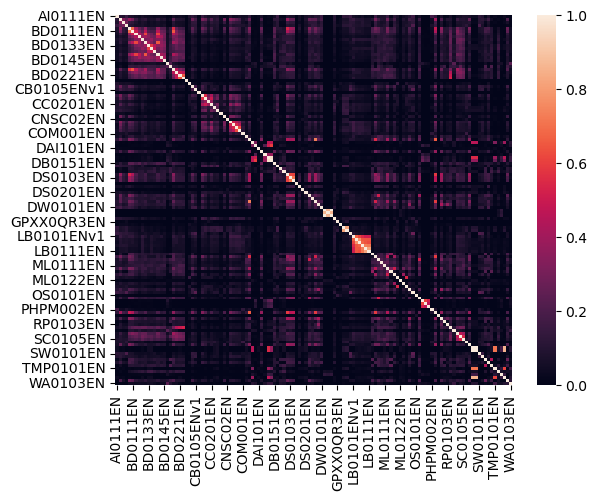

In [23]:
sns.heatmap(item_sim_df)

In [ ]:
u_users=rating_sparse_df.user.unique()
sim=np.zeros((len(u_users),len(u_users)))
for i,user_1 in enumerate(u_users):
    for user_2 in u_users[i+1:]:
        sim[i][i+1]=scipy.spatial.distance.cosine(rating_sparse_df[rating_sparse_df['user']==user_1].iloc[:,1:].values[0],rating_sparse_df[rating_sparse_df['user']==user_2].iloc[:,1:].values[0])

KeyboardInterrupt: 

In [ ]:

sns.heatmap(sim)

Next, you need to implement NMF-based collaborative filtering, and you may choose one of the two following implementation options: 
- The first one is to use `Surprise` which is a popular and easy-to-use Python recommendation system library. 
- The second way is to implement it with `numpy`, `pandas`, and `sklearn`. You may need to write a lot of low-level implementation code along the way.


## Implementation Option 1: Use **Surprise** library (recommended)


*Surprise* is a Python scikit library for recommender systems. It is simple and comprehensive to build and test different recommendation algorithms. First let's install it:


In [8]:
#!pip install scikit-surprise

We import required classes and methods


In [9]:
from surprise import NMF
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

In [10]:
# Save the rating dataframe to a CSV file
rating_df.to_csv("course_ratings.csv", index=False)

# Read the course rating dataset with columns user item rating
reader = Reader(line_format='user item rating', sep=',', skip_lines=1, rating_scale=(3, 5))

# Load the dataset from the CSV file
course_dataset = Dataset.load_from_file("course_ratings.csv", reader=reader)

Now  we split the data into a train-set and test-set:


In [11]:
trainset, testset = train_test_split(course_dataset, test_size=0.3)

Then check how many users and items we can use to fit the KNN model:


In [12]:
print(f"Total {trainset.n_users} users and {trainset.n_items} items in the trainingset")

Total 31301 users and 124 items in the trainingset


### TASK: Perform NMF-based collaborative filtering on the course-interaction matrix


_TODO: Fit a NMF model using the trainset and evaluate the results using the testset_ The code will be very similar to the KNN-based collaborative filtering, you just need to use the `NMF()` model.


In [13]:
## WRITE YOUR CODE HERE:

# - Define a NMF model NMF(verbose=True, random_state=123)
model=NMF(n_factors=100,random_state=123,n_epochs=100)
# - Train the NMF on the trainset, and predict ratings for the testset
model.fit(trainset)
surprise_1=model.pu
surprise_2=model.qi
predictions=model.test(testset)
# - Then compute RMSE
accuracy.mse(predictions)
# more NMF model hyperparamets can be found here:

# https://surprise.readthedocs.io/en/stable/matrix_factorization.html

# You may try different hyperparamet combinations to see which one has the best performance

MSE: 0.8333


0.8333239463470824

In [30]:
preds=pd.DataFrame(predictions)
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(y_true=preds['r_ui'],y_pred=preds['est'])

0.9128657876966813

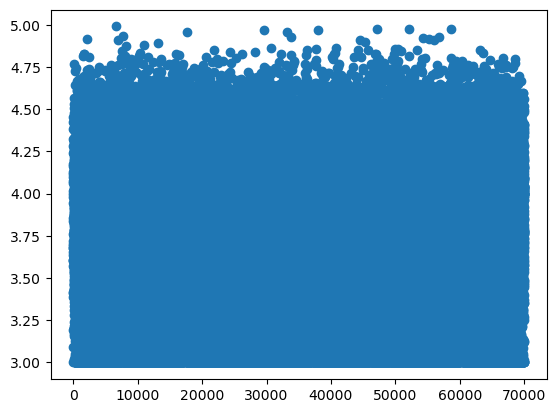

In [33]:
import matplotlib.pyplot as plt
plt.scatter(range(len(preds['est'])),preds['est'])

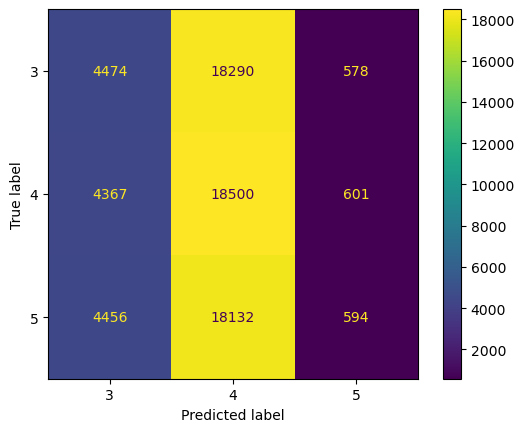

In [ ]:

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_true=preds['r_ui'],y_pred=preds['est'].map(np.round),labels=[3,4,5])

In [15]:
preds

,uid,iid,r_ui,est,details
0,1510003,BD0221EN,5.0,3.089855,{'was_impossible': False}
1,1690025,CNSC02EN,5.0,3.998763,"{'was_impossible': True, 'reason': 'User and i..."
2,1316338,BC0101EN,4.0,4.065445,{'was_impossible': False}
3,573764,LB0107ENv1,4.0,4.384993,{'was_impossible': False}
4,1610852,BC0201EN,5.0,4.323361,{'was_impossible': False}
...,...,...,...,...,...
69987,935911,ML0101ENv3,3.0,3.000000,{'was_impossible': False}
69988,1348776,BC0101EN,3.0,4.244015,{'was_impossible': False}
69989,677959,WA0101EN,4.0,4.095499,{'was_impossible': False}
69990,1308462,BD0121EN,3.0,3.716008,{'was_impossible': False}


<details>
    <summary>Click here for Hints</summary>

* Create a model by calling `NMF()` class and set parameters to `init_low=0.5, init_high = 5.0, n_factors=32`. 
* Fit it  with `trainset` by using `model.fit(trainset)`.  
* Record predictions to the `testset`  by using `model.test(testset).
* Compute the accuracy by using `accuracy.rmse(predictions)`


To learn more detailed usages about _Surprise_ library, visit its website from [here](https://surprise.readthedocs.io/en/stable/getting_started.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML321ENSkillsNetwork817-2022-01-01)


## Implementation Option 2: Use `numpy`, `pandas`, and `sklearn`.


If you do not prefer the one-stop Suprise solution, you may implement the KNN model using `numpy`, `pandas`, and possibly `sklearn`:


In [15]:
from sklearn.decomposition import NMF as sklearn_NMF
from sklearn.model_selection import train_test_split as sklearn_tts

In [16]:
rating_sparse_df.to_numpy()

array([[2.000000e+00, 0.000000e+00, 4.000000e+00, ..., 0.000000e+00,
        5.000000e+00, 0.000000e+00],
       [4.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        3.000000e+00, 3.000000e+00],
       [5.000000e+00, 3.000000e+00, 5.000000e+00, ..., 5.000000e+00,
        0.000000e+00, 3.000000e+00],
       ...,
       [2.102680e+06, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [2.102983e+06, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [2.103039e+06, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])

In [17]:
rating_df.item.nunique()

126

In [18]:
x_train,x_test = sklearn_tts(rating_df, test_size=0.3)

In [19]:
x_train_raw=x_train.pivot_table(index='user',columns='item',values='rating')
x_train_raw

item,AI0111EN,BC0101EN,BC0201EN,BC0202EN,BD0101EN,BD0111EN,BD0115EN,BD0121EN,BD0123EN,BD0131EN,...,SW0201EN,TA0105,TA0105EN,TA0106EN,TMP0101EN,TMP0105EN,TMP0106,TMP107,WA0101EN,WA0103EN
user,,,,,,,,,,,,,,,,,,,,,
2,NaN,4.0,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN,...,NaN,5.0,NaN,4.0,NaN,NaN,3.0,NaN,5.0,NaN
4,NaN,NaN,NaN,NaN,5.0,3.0,4.0,NaN,3.0,NaN,...,NaN,4.0,NaN,NaN,NaN,3.0,3.0,NaN,3.0,3.0
5,3.0,NaN,5.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,4.0,NaN,NaN,NaN,5.0,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2102054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2102356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
x_test_raw=x_test.pivot_table(index='user',columns='item',values='rating')
x_test_raw

item,AI0111EN,BC0101EN,BC0201EN,BC0202EN,BD0101EN,BD0111EN,BD0115EN,BD0121EN,BD0123EN,BD0131EN,...,SW0101EN,SW0201EN,TA0105,TA0105EN,TA0106EN,TMP0101EN,TMP0105EN,TMP0106,WA0101EN,WA0103EN
user,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,4.0,4.0,NaN,3.0
9,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2101673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2102054,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
x_train_raw.reset_index().rename_axis(index=None, columns=None)

,user,AI0111EN,BC0101EN,BC0201EN,BC0202EN,BD0101EN,BD0111EN,BD0115EN,BD0121EN,BD0123EN,...,SW0201EN,TA0105,TA0105EN,TA0106EN,TMP0101EN,TMP0105EN,TMP0106,TMP107,WA0101EN,WA0103EN
0,2,NaN,4.0,NaN,NaN,5.0,4.0,NaN,NaN,NaN,...,NaN,5.0,NaN,4.0,NaN,NaN,3.0,NaN,5.0,NaN
1,4,NaN,NaN,NaN,NaN,5.0,3.0,4.0,NaN,3.0,...,NaN,4.0,NaN,NaN,NaN,3.0,3.0,NaN,3.0,3.0
2,5,3.0,NaN,5.0,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,4.0,NaN,NaN,NaN,5.0,NaN,NaN
3,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31433,2101601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31434,2102054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31435,2102356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31436,2102680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
pd.melt(x_train_raw.reset_index().rename_axis(index=None, columns=None),id_vars=['user']).dropna().sort_values(by=['user','variable'])

,user,variable,value
31438,2,BC0101EN,4.0
125752,2,BD0101EN,5.0
157190,2,BD0111EN,4.0
314380,2,BD0133EN,3.0
345818,2,BD0135EN,4.0
...,...,...,...
2672228,2102680,ML0109EN,4.0
2703666,2102680,ML0111EN,3.0
2955170,2102680,ML0151EN,5.0
3206674,2102680,PY0101EN,4.0


In [23]:
x_train_raw.reset_index().rename_axis(index=None, columns=None).fillna(0).iloc[:,1:].to_numpy().shape

(31438, 125)

In [24]:
x_test_raw.reset_index().rename_axis(index=None, columns=None).fillna(0).iloc[:,1:].to_numpy().shape

(25558, 119)

In [ ]:
model_sk=sklearn_NMF(n_components=32).fit(x_train_raw.reset_index().rename_axis(index=None, columns=None).fillna(0).iloc[:,1:].to_numpy())

In [ ]:
## WRITE YOUR CODE HERE:

## One solution could be:

## - Use the NMF() class provided by sklearn to decompose the original user-item interaction matrix
#x_train,x_test = sklearn_tts(rating_sparse_df.to_numpy()[:,1:], test_size=.3,random_state=123)

#model_sk=sklearn_NMF(n_components=32)
#model_sk.fit(x_train)


## - For each rating in the test dataset, estimate its rating using the dot product of matrix U and matrix I, following the previous equation

## - Calculate the RMSE for the entire test dataset



NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=32, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [ ]:
i=model_sk.components_

In [ ]:
x_train_raw.reset_index().rename_axis(index=None, columns=None).fillna(0).iloc[:,1:].to_numpy()

array([[0., 4., 0., ..., 0., 5., 0.],
       [0., 0., 0., ..., 0., 3., 0.],
       [0., 0., 5., ..., 5., 0., 3.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
w=model_sk.transform(x_train_raw.reset_index().rename_axis(index=None, columns=None).fillna(0).iloc[:,1:].to_numpy())

In [ ]:
u=model_sk.transform(x_test_raw.reset_index().rename_axis(index=None, columns=None).fillna(0).iloc[:,1:].to_numpy())

ValueError: Array with wrong shape passed to NMF (input H). Expected (32, 118), but got (32, 125) 

In [ ]:
len(sorted(list(set(x_train.user)-set(x_test.user))))

8203

In [ ]:
len(sorted(list(set(x_test.user)-set(x_train.user))))

2553

In [ ]:
u.shape

(10171, 32)

In [ ]:
i.shape

(32, 126)

In [ ]:
surprise_1.shape

(31363, 32)

In [ ]:
w.shape

(23730, 32)

In [ ]:
np.dot(surprise_1,np.transpose(surprise_2)).shape

(31363, 122)

In [ ]:
np.dot(w,i).shape

(23730, 126)

In [ ]:
test=np.dot(np.transpose(u),i)
test.shape

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
rmse=[]
for i in range(x_test.shape[0]):
    rmse.append(np.sqrt(mean_squared_error(x_test[i],test[i])))

In [ ]:
np.mean(rmse)

0.3104612799233195

In [ ]:
mean_squared_error(x_test,test)

0.15603098355569722

In [ ]:
np.sqrt(mean_squared_error(x_test,test))

0.39500757404852027

In [ ]:
predictions

[Prediction(uid='245399', iid='RP0101EN', r_ui=5.0, est=3, details={'was_impossible': False}),
 Prediction(uid='597976', iid='DS0101EN', r_ui=5.0, est=3, details={'was_impossible': False}),
 Prediction(uid='325595', iid='BD0223EN', r_ui=5.0, est=3, details={'was_impossible': False}),
 Prediction(uid='980794', iid='ML0101EN', r_ui=5.0, est=3, details={'was_impossible': False}),
 Prediction(uid='725760', iid='BC0101EN', r_ui=3.0, est=3, details={'was_impossible': False}),
 Prediction(uid='2', iid='ML0122EN', r_ui=4.0, est=3, details={'was_impossible': False}),
 Prediction(uid='1027804', iid='CC0250EN', r_ui=4.0, est=3, details={'was_impossible': False}),
 Prediction(uid='1684405', iid='DB0101EN', r_ui=3.0, est=3, details={'was_impossible': False}),
 Prediction(uid='1371668', iid='CO0201EN', r_ui=5.0, est=3, details={'was_impossible': False}),
 Prediction(uid='1840885', iid='DV0101EN', r_ui=5.0, est=3, details={'was_impossible': False}),
 Prediction(uid='1289931', iid='RP0101EN', r_ui=5.0

In [ ]:
test

NameError: name 'test' is not defined

## Summary


In this lab, you have learned and practiced NMF-based collaborative filtering. The basic idea is to decompose the original user-item interaction matrix into two smaller and dense user and item matrices. Then, we have built the two matrices, we can easily estimate the unknown ratings via the dot product of specific row in user matrix and specific column in item matrix.


## Authors


[Yan Luo](https://www.linkedin.com/in/yan-luo-96288783/)


### Other Contributors


```Toggle## Change Log
```


```Toggle|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
```
```Toggle|-|-|-|-|
```
```Toggle|2021-10-25|1.0|Yan|Created the initial version|
```


Copyright © 2022 IBM Corporation. All rights reserved.
